# Resume Parsing

So basically, we want to create a entity ruler ro parse real-resume and get the "skills".

But for your assignment, i will as k you to extract education

In [1]:
import numpy as np
import pandas as pd

df_resume = pd.read_csv('../data/resume.csv')

In [2]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[0:1000] #optionally, if your computer is fast
df_resume.shape

(1000, 4)

# 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [4]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = "../data/skills.jsonl"

In [5]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [6]:
doc = nlp("Chaky loves deep learning")
doc.ents

(Chaky, deep learning)

## 3. Let's try to extract skills from this resume.csv

In [7]:
from spacy.lang.en.stop_words import STOP_WORDS

#before that, let's clean our resume.csv dataframe
def preprocessing(sentence):

    stopwords = list(STOP_WORDS)

    doc = nlp(sentence)

    cleaned_tokens = []

    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM':
                cleaned_tokens.append(token.lemma_.lower().strip())
    
    return " ".join(cleaned_tokens)

In [8]:
#let's try Chaky, if you feel too dangerous
#random sampling
random_resume = df_resume.Resume_str.iloc[3]
random_resume[:300]

'         DENTAL HYGIENIST           Professional Summary    I am a dedicated and energetic Dental Hygienist with a total of sixteen years experience in the dental profession. My focus has always been to provide exceptional patient care, counseling and motivation to each of my patients. I have experi'

In [9]:
preprocessing(random_resume[:300])

'dental hygienist professional summary i dedicated energetic dental hygienist total sixteen year experience dental profession my focus provide exceptional patient care counseling motivation patient i experi'

In [10]:
#let's apply to the whole dataframe
for i,row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i,'Clean_resume'] = clean_text

In [11]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
2024,29061628,CUSTOMER SERVICE REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,customer service representative present accomp...
90,17150707,HR SHARED SERVICES ANALYST ...,"<div class=""fontsize fontface vmargins hmargin...",HR,hr shared services analyst summary versatile h...
2040,26130673,PUBLIC RELATIONS INTERN Sum...,"<div class=""fontsize fontface vmargins hmargin...",PUBLIC-RELATIONS,public relations intern summary ambitious serv...
2366,14248724,DENTAL HYGIENIST Profession...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,dental hygienist professional summary i dedica...
133,15936656,FLORAL DESIGNER Summary Flor...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,floral designer summary floral designer year e...


## 4. Let's really extract skills!!

In [12]:
def get_skills(text):
    #pass the text to the nlp
    doc = nlp(text) #note that this nlp already know skills
    skills = []
    #look at the ents
    for ent in doc.ents:
        #if the ent.label_ is SKILL, then we append to some list
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
    return skills

def unique_skills(x):
    return list(set(x))

In [13]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume
2024,29061628,CUSTOMER SERVICE REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,customer service representative present accomp...


In [14]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [15]:
df_resume.head(1)

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills
2024,29061628,CUSTOMER SERVICE REPRESENTATIVE ...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,customer service representative present accomp...,"[material, testing, specification, schedule, s..."


In [16]:
df_resume.Skills.iloc[0]

['material', 'testing', 'specification', 'schedule', 'software']

## 5. Visualization

which skills is most important in information management

In [17]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [18]:
category = 'INFORMATION-TECHNOLOGY'

cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(50, 6)

In [19]:
all_skill = np.concatenate(df_resume_it.Skills.values)

In [24]:
#counting
from collections import Counter, OrderedDict
counting = Counter(all_skill)
counting = OrderedDict(counting.most_common(10))

In [25]:
counting

OrderedDict([('support', 47),
             ('software', 43),
             ('business', 35),
             ('server', 33),
             ('security', 32),
             ('design', 31),
             ('database', 29),
             ('windows', 28),
             ('project management', 21),
             ('documentation', 19)])

<BarContainer object of 10 artists>

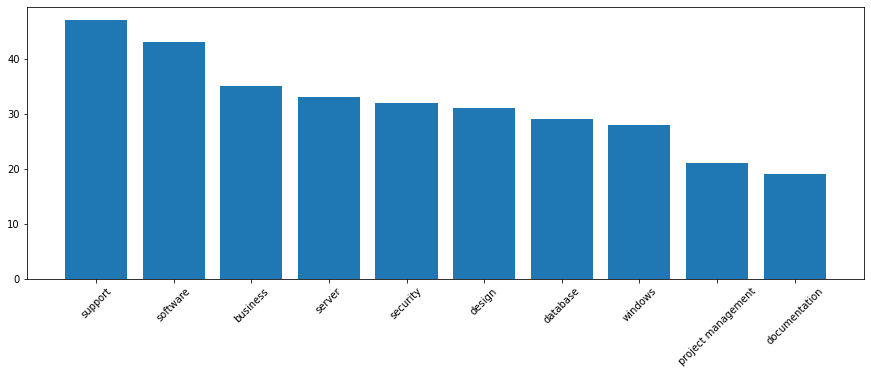

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.xticks(rotation = 45)
plt.bar(counting.keys(),counting.values())

## 6. Name Entity Recongnition

In [34]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[43]

In [35]:
doc = nlp(text)

In [41]:
nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component         Assigns               Requires   Scores             Retokenizes
-   ---------------   -------------------   --------   ----------------   -----------
0   tok2vec           doc.tensor                                          False      
                                                                                     
1   tagger            token.tag                        tag_acc            False      
                                                                                     
2   parser            token.dep                        dep_uas            False      
                      token.head                       dep_las                       
                      token.is_sent_start              dep_las_per_type              
                      doc.sents                        sents_p                       
                                                       sents

{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'tagger': {'assigns': ['token.tag'],
   'requires': [],
   'scores': ['tag_acc'],
   'retokenizes': False},
  'parser': {'assigns': ['token.dep',
    'token.head',
    'token.is_sent_start',
    'doc.sents'],
   'requires': [],
   'scores': ['dep_uas',
    'dep_las',
    'dep_las_per_type',
    'sents_p',
    'sents_r',
    'sents_f'],
   'retokenizes': False},
  'attribute_ruler': {'assigns': [],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False},
  'ner': {'assigns': ['doc.ents', 'token.ent_iob', 'token.ent_type'],
   'requires': [],
   'scores': ['ents_f', 'ents_p', 'ents_r', 'ents_per_type'],
   'retokenizes': False},
  'entity_ruler': {'assigns': ['doc.ents', 'token.ent_type', 'token.ent_iob'],
   'requires': [],
   'scores': ['ents_f', 'ent

In [39]:
colors = {"SKILL" : "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc,style='ent',options=options)

## 7. Let's load the PDF - add so realism

In [54]:
# !pip install PyPDF2

In [50]:
from PyPDF2 import PdfReader

reader = PdfReader("../data/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text() 

In [51]:
text = preprocessing(text)

In [52]:
doc = nlp(text)

In [53]:
colors = {"SKILL" : "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}
displacy.render(doc,style='ent',options=options)

In [55]:
#last thing i go to assignment
#collect all the skill and put it into a list

skills = []
for ent in doc.ents:
    if ent.label_ == 'SKILL':
        skills.append(ent.text)

print(set(skills))

{'algorithms', 'deep learning', 'engineering', 'computer science', 'ai'}
